The goal of the project is to predict telecom operator clients that are likely to cancel their contract. Such clients can then be targeted via discount or other programs to keep them with the company.

We have data on 3333 clients with various information on how they consume the services, and whether they have cancelled their contract.

Leaving clients constitute 14% of total clients number. Therefore this is an umbalanced classification problem. I address that in 2 ways and compare them: 
- passing the imbalance information to classifiers via 'class_weight' parameter.
- upscaling the minority class via imblearn.over_sampling RandomOverSampler and SMOTENC. 
  - The 1st generates new items by duplicating the existing ones, the item to duplicate is picked randomly, the process is repeated untill the both classes have 0.5/0.5 weights.
  - The 2nd - by interpolating values of existing items for continious features, and for categorical features by duplicating the most common value among k nearest neighbours. See https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

I have applied Logistic Regression, SVM, Random Forests, and Extremely Randomized Trees classifiers.
The best results were achieved with the Forests classifiers, specifically Extremely Randomized Trees: precision: 0.79; recall: 0.78.   
And with the 'class_weight' parameter, applying the mentioned oversampling gives similar but slightly worse results.

Data analysis steps taken are covered in Markdown blocks close to the relevant code blocks.

In [53]:
import pandas 
import sklearn 
from sklearn.preprocessing import OneHotEncoder
pandas.set_option("display.precision", 4)

In [54]:
dataFrame = pandas.read_csv('telecom_churn.txt')
dataFrame

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [55]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null object
Voice mail plan           3333 non-null object
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64


In [56]:
dataFrame['Churn'].value_counts(normalize=True)

False    0.8551
True     0.1449
Name: Churn, dtype: float64

In [57]:
churnRatio = dataFrame['Churn'].value_counts(normalize=True)[1]
churnRatio

0.14491449144914492

We have 3 categorical features in the dataset: State, International plan, Voice mail plan. We need to convert them to numerical types so the classifiers would be able to process them.  
The latter 2 features are simply yes/no, so here we can use the simplest approach by assigning different numbers to different categories (LabelEncoder).  
However, doing that for State leads to an implication that there is a notion of order and comparison between the categories. E.g. if state=California gets assigned the value of 5 and state=Texas: 40, it may begin to mean to the classifier that the latter is 8 times bigger (in any sense) than the former, which is not neccessary true.  
There are categorical data transformation approaches that address that disadvantage: variations of One-hot Encoding Scheme, for our case we can apply Dummy Coding Scheme. But the disadvantage is increasing the number of features. Our dataset is rather small (3333 items), and using Dummy Coding for State feature we increase the number of features from 19 to 68. Which leads us to  known High Dimensionality Problem, because 19 initial features are already more than would be the ideal for 3333 items. I have tried Dummy Coding for State and it gave worse results than using LabelEncoder.

In [58]:
from sklearn.preprocessing import LabelEncoder
dataFrame['StateLabel'] = LabelEncoder().fit_transform(dataFrame['State'])
dataFrame.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,StateLabel
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,False,16
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,False,35
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,False,31
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,False,35
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,False,36


In [59]:
# stateEncodedVector = pandas.get_dummies(dataFrame['State'], drop_first=True)
# pandas.set_option('display.max_columns', 100) 
# dataFrame = pandas.concat([dataFrame, stateEncodedVector], axis=1)
# dataFrame.head()

In [60]:
dataFrame = dataFrame.drop(['State'], axis=1, inplace=False)

In [61]:
yesNoMapping = {'No' : 0, 'Yes' : 1}
dataFrame['International plan'] = dataFrame['International plan'].map(yesNoMapping)
dataFrame['Voice mail plan'] = dataFrame['Voice mail plan'].map(yesNoMapping)

Y = dataFrame['Churn']
X = dataFrame.drop(['Churn'], axis=1, inplace=False)

X.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,StateLabel
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,16
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,35
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,31
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,35
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,36


In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null int64
Voice mail plan           3333 non-null int64
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64
StateLabel                3333 non-null int64
dty

In [63]:
Y

0       False
1       False
2       False
3       False
4       False
        ...  
3328    False
3329    False
3330    False
3331    False
3332    False
Name: Churn, Length: 3333, dtype: bool

In [64]:
from sklearn.preprocessing import StandardScaler
Xscaled = StandardScaler().fit_transform(X)
Xscaled.shape

(3333, 19)

I have analysed feature importances (via Extremely Randomized Trees) and tried removing a number of the least significant featues. That has not improved the trees classification results, however it improved e.g. SVM results, but they are still below the trees' results.

Feature ranking:
1. feature 7 Total day charge (0.126361)
2. feature 5 Total day minutes (0.122620)
3. feature 17 Customer service calls (0.120607)
4. feature 2 International plan (0.073578)
5. feature 8 Total eve minutes (0.056383)
6. feature 10 Total eve charge (0.055384)
7. feature 15 Total intl calls (0.052111)
8. feature 14 Total intl minutes (0.044741)
9. feature 16 Total intl charge (0.043973)
10. feature 13 Total night charge (0.037985)
11. feature 11 Total night minutes (0.037816)
12. feature 6 Total day calls (0.035600)
13. feature 0 Account length (0.034291)
14. feature 12 Total night calls (0.033982)
15. feature 9 Total eve calls (0.033204)
16. feature 18 StateLabel (0.032738)
17. feature 1 Area code (0.022659)
18. feature 4 Number vmail messages (0.018068)
19. feature 3 Voice mail plan (0.017900)


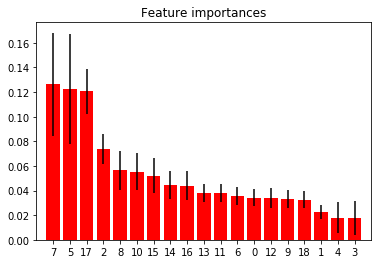

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250)
forest.fit(Xscaled, Y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [66]:
from sklearn.feature_selection import SelectFromModel
Xreduced = SelectFromModel(forest, prefit=True, threshold=0.04).transform(Xscaled)
Xreduced.shape

(3333, 9)

To account for the class imbalance, we use stratification during train/test split. And during cross validation in GridSearchCV (the default setting). The cross valudation is using 5 folds (the default setting).

In [67]:
testSize = 0.4
from sklearn.model_selection import train_test_split
XfullTrain, XfullTest, YfullTrain, YfullTest = train_test_split(Xscaled, Y, test_size=testSize, stratify=Y)
XreducedTrain, XreducedTest, YreducedTrain, YreducedTest = train_test_split(Xreduced, Y, test_size=testSize, stratify=Y)

In [68]:
from imblearn.over_sampling import RandomOverSampler
XfullTrainUpsampledRnd, YfullTrainUpsampledRnd = RandomOverSampler().fit_resample(XfullTrain, YfullTrain)
print(YfullTrain.value_counts(normalize=True))
print(YfullTrainUpsampled.value_counts(normalize=True))

False    0.8549
True     0.1451
Name: Churn, dtype: float64
True     0.5
False    0.5
Name: Churn, dtype: float64


In [69]:
XreducedTrainUpsampledRnd, YreducedTrainUpsampledRnd = RandomOverSampler().fit_resample(XreducedTrain, YreducedTrain)
print(YreducedTrain.value_counts(normalize=True))
print(YreducedTrainUpsampled.value_counts(normalize=True))

False    0.8549
True     0.1451
Name: Churn, dtype: float64
True     0.5
False    0.5
Name: Churn, dtype: float64


In [70]:
from imblearn.over_sampling import SMOTENC
XfullTrainUpsampledSm, YfullTrainUpsampledSm = SMOTENC(categorical_features=[1,2,3,18]).fit_resample(XfullTrain, YfullTrain)
print(YfullTrainUpsampled.value_counts(normalize=True))

True     0.5
False    0.5
Name: Churn, dtype: float64


In [71]:
#categorical_features=[0] because features before International plan were deleted. Chek that index every time you rerun the deletion because it varies due to randomness
XreducedTrainUpsampledSm, YreducedTrainUpsampledSm = SMOTENC(categorical_features=[0]).fit_resample(XreducedTrain, YreducedTrain)
print(YreducedTrainUpsampled.value_counts(normalize=True))

True     0.5
False    0.5
Name: Churn, dtype: float64


We select the best model hyper parameters using F_1.5 model performance metric. Because we want to give 1.5 times more weight to recall comparing to precision. Because it's more important to be able to find the leaving clients (recall), we can tolerate certain level of mistakes of classifying non-leaving clients as leaving (precision).

Accuracy metric is not useful with imbalanced classes, we include it here just for the reference. But it's really should, and is - avoided as far as model performance assessment goes.

In [72]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support
import os

def gridSearchCvAndReport(classifier, paramsSearchGrid, Xtrain, Xtest, Ytrain, Ytest):
    accuracyScorer = make_scorer(accuracy_score)
    precisionScorer = make_scorer(precision_score)
    recallScorer = make_scorer(recall_score)
    betaOfF=1.5
    fBetaScorer = make_scorer(fbeta_score, beta=betaOfF)
    scorings = {'accuracy':accuracyScorer, 'precision':precisionScorer, 'recall':recallScorer, 'fBeta':fBetaScorer}

    optimizer = GridSearchCV(
        classifier, paramsSearchGrid, scoring=scorings, refit='fBeta'
    )
    optimizer.fit(Xtrain, Ytrain)

    print("Best parameters found on train set:")
    print(optimizer.best_params_)
    print()
    print("Scores of all parameters sets:")
    print()
    accuracyMeans = optimizer.cv_results_['mean_test_accuracy']
    accuracyStds = optimizer.cv_results_['std_test_accuracy']
    precisionMeans = optimizer.cv_results_['mean_test_precision']
    precisionStds = optimizer.cv_results_['std_test_precision']
    recallMeans = optimizer.cv_results_['mean_test_recall']
    recallStds = optimizer.cv_results_['std_test_recall']
    fBetaMeans = optimizer.cv_results_['mean_test_fBeta']
    fBetaStds = optimizer.cv_results_['std_test_fBeta']
    for accuracyMean, accuracyStd, precisionMean, precisionStd, recallMean, recallStd, fBetaMean, fBetaStd, params in zip(accuracyMeans, accuracyStds, precisionMeans, precisionStds, recallMeans, recallStds, fBetaMeans, fBetaStds, optimizer.cv_results_['params']):
        #if params == optimizer.best_params_ :
            print("* accuracy: %0.3f (+/-%0.03f), precision: %0.3f (+/-%0.03f), recall: %0.3f (+/-%0.03f), fB: %0.3f (+/-%0.03f) for %r" \
                  % (accuracyMean, accuracyStd * 2, precisionMean, precisionStd * 2, recallMean, recallStd * 2, fBetaMean, fBetaStd * 2, params))
    print()
    print("Prediction on test set:")
    Ypredicted = optimizer.predict(Xtest)
    p_r_fBeta_s = precision_recall_fscore_support(Ytest, Ypredicted, beta=betaOfF, average='binary')
    print("accuracy: %0.2f; precision: %0.2f; recall: %0.2f; fB: %0.2f" % (accuracy_score(Ytest, Ypredicted, normalize=True), p_r_fBeta_s[0], p_r_fBeta_s[1], p_r_fBeta_s[2]))
    print("model suggests to target %0.2f of total clients" % (p_r_fBeta_s[1] / p_r_fBeta_s[0] * churnRatio)) # because recall / precision = ratio of <number of clients the model classifies as churn> to <number of  clients that are trully churn>. See https://monosnap.com/file/sQHSzs9QcKh1BXAkzJfB3rrPMBSbRQ
    #print("classification_report: ")
    #print(classification_report(Ytest, Ypredicted))
    
    os.system("printf '\7'") #bell
    
def gridSearchCvAndReportForNonReducedAndReduced(getClassifier, paramsSearchGrid):
    print('ON FULL FEATURE SET')
    gridSearchCvAndReport(getClassifier(), paramsSearchGrid, XfullTrain, XfullTest, YfullTrain, YfullTest)
    
    print('\nON REDUCED FEATURE SET')
    gridSearchCvAndReport(getClassifier(), paramsSearchGrid, XreducedTrain, XreducedTest, YreducedTrain, YreducedTest)
    
def gridSearchCvAndReportForNonReducedAndReducedUpsampled(getClassifier, paramsSearchGrid):
    print('\nON FULL FEATURE SET, UPSAMPLED WITH RANDOM REPEAT')
    gridSearchCvAndReport(getClassifier(), paramsSearchGrid, XfullTrainUpsampledRnd, XfullTest, YfullTrainUpsampledRnd, YfullTest)
    
    print('\nON REDUCED FEATURE SET, UPSAMPLED WITH RANDOM REPEAT')
    gridSearchCvAndReport(getClassifier(), paramsSearchGrid, XreducedTrainUpsampledRnd, XreducedTest, YreducedTrainUpsampledRnd, YreducedTest)
    
    print('\nON FULL FEATURE SET, UPSAMPLED WITH SMOTE-NC')
    gridSearchCvAndReport(getClassifier(), paramsSearchGrid, XfullTrainUpsampledSm, XfullTest, YfullTrainUpsampledSm, YfullTest)
    
    print('\nON REDUCED FEATURE SET, UPSAMPLED WITH SMOTE-NC')
    gridSearchCvAndReport(getClassifier(), paramsSearchGrid, XreducedTrainUpsampledSm, XreducedTest, YreducedTrainUpsampledSm, YreducedTest)

In [75]:
from sklearn.linear_model import LogisticRegression
gridSearchCvAndReportForNonReducedAndReduced(lambda: LogisticRegression(), paramsSearchGrid=[
    {'solver':['liblinear','lbfgs'], 'C': [0.0005,0.001,0.005,0.05,0.1,0.5,1,5], 'penalty': ['l2'], 'class_weight': ['balanced']}
])
gridSearchCvAndReportForNonReducedAndReducedUpsampled(lambda: LogisticRegression(), paramsSearchGrid=[
    {'solver':['liblinear','lbfgs'], 'C': [0.0005,0.001,0.005,0.05,0.1,0.5,1,5], 'penalty': ['l2'], 'class_weight': [None]}
])

ON FULL FEATURE SET
Best parameters found on train set:
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Scores of all parameters sets:

* accuracy: 0.630 (+/-0.031), precision: 0.259 (+/-0.032), recall: 0.834 (+/-0.121), fB: 0.496 (+/-0.064) for {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
* accuracy: 0.746 (+/-0.030), precision: 0.332 (+/-0.045), recall: 0.738 (+/-0.150), fB: 0.535 (+/-0.085) for {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
* accuracy: 0.661 (+/-0.031), precision: 0.278 (+/-0.032), recall: 0.834 (+/-0.126), fB: 0.516 (+/-0.065) for {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
* accuracy: 0.752 (+/-0.027), precision: 0.338 (+/-0.043), recall: 0.741 (+/-0.148), fB: 0.541 (+/-0.084) for {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
* accuracy: 0.725 (+/-0.035), precision: 0.323 (+/-0.038), recall: 0.814 (+/

Best parameters found on train set:
{'C': 0.0005, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

Scores of all parameters sets:

* accuracy: 0.732 (+/-0.036), precision: 0.699 (+/-0.035), recall: 0.817 (+/-0.038), fB: 0.776 (+/-0.033) for {'C': 0.0005, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
* accuracy: 0.740 (+/-0.026), precision: 0.750 (+/-0.036), recall: 0.722 (+/-0.039), fB: 0.730 (+/-0.029) for {'C': 0.0005, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
* accuracy: 0.742 (+/-0.027), precision: 0.714 (+/-0.033), recall: 0.807 (+/-0.031), fB: 0.776 (+/-0.023) for {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
* accuracy: 0.744 (+/-0.027), precision: 0.753 (+/-0.039), recall: 0.728 (+/-0.046), fB: 0.736 (+/-0.033) for {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
* accuracy: 0.749 (+/-0.033), precision: 0.742 (+/-0.042), recall: 0.765 (+/-0.015), fB: 0.757 (+/-0.022) for {'C': 0.005

In [76]:
gridSearchCvAndReportForNonReducedAndReduced(lambda: SVC(), paramsSearchGrid=[
    {'kernel': ['linear'], 'C': [0.5,1,10], 'gamma':['scale','auto'], 'class_weight': [None,'balanced']}, 
    {'kernel': ['rbf'], 'C': [0.1,0.5,1,2,5,8,10,100,1000], 'gamma':['scale','auto'], 'class_weight': [None,'balanced']},
    {'kernel': ['poly'], 'degree':[2,3,4], 'C': [0.05,0.1,0.5,1,5], 'gamma':['scale','auto'], 'class_weight': ['balanced']},
    {'kernel': ['sigmoid'], 'C': [0.05,0.1,0.5,1,5], 'gamma':['scale','auto'], 'class_weight': ['balanced']}
])

ON FULL FEATURE SET


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined a

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined a

Best parameters found on train set:
{'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

Scores of all parameters sets:

* accuracy: 0.855 (+/-0.000), precision: 0.000 (+/-0.000), recall: 0.000 (+/-0.000), fB: 0.000 (+/-0.000) for {'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.855 (+/-0.000), precision: 0.000 (+/-0.000), recall: 0.000 (+/-0.000), fB: 0.000 (+/-0.000) for {'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.763 (+/-0.025), precision: 0.358 (+/-0.035), recall: 0.797 (+/-0.122), fB: 0.578 (+/-0.068) for {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.763 (+/-0.025), precision: 0.358 (+/-0.035), recall: 0.797 (+/-0.122), fB: 0.578 (+/-0.068) for {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.855 (+/-0.000), precision: 0.000 (+/-0.000), recall: 0.000 (+/-0.000), fB: 0.000 (+/-0.000) for {'C': 1, 'cla

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined a

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined a

Best parameters found on train set:
{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

Scores of all parameters sets:

* accuracy: 0.855 (+/-0.000), precision: 0.000 (+/-0.000), recall: 0.000 (+/-0.000), fB: 0.000 (+/-0.000) for {'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.855 (+/-0.000), precision: 0.000 (+/-0.000), recall: 0.000 (+/-0.000), fB: 0.000 (+/-0.000) for {'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.767 (+/-0.059), precision: 0.359 (+/-0.076), recall: 0.748 (+/-0.089), fB: 0.560 (+/-0.080) for {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.767 (+/-0.059), precision: 0.359 (+/-0.076), recall: 0.748 (+/-0.089), fB: 0.560 (+/-0.080) for {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.855 (+/-0.000), precision: 0.000 (+/-0.000), recall: 0.000 (+/-0.000), fB: 0.000 (+/-0.000) for {'C': 1, 'class

In [79]:
gridSearchCvAndReportForNonReducedAndReducedUpsampled(lambda: SVC(), paramsSearchGrid=[
    {'kernel': ['linear'], 'C': [0.5,1,10], 'gamma':['scale','auto'], 'class_weight': [None]}, 
    {'kernel': ['rbf'], 'C': [0.1,0.5,1,2,5,8,10,100,1000], 'gamma':['scale','auto'], 'class_weight': [None]},
    {'kernel': ['poly'], 'degree':[2,3,4], 'C': [0.05,0.1,0.5,1,5], 'gamma':['scale','auto'], 'class_weight': [None]},
    {'kernel': ['sigmoid'], 'C': [0.05,0.1,0.5,1,5], 'gamma':['scale','auto'], 'class_weight': [None]}
])


ON FULL FEATURE SET, UPSAMPLED WITH RANDOM REPEAT
Best parameters found on train set:
{'C': 100, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}

Scores of all parameters sets:

* accuracy: 0.780 (+/-0.034), precision: 0.762 (+/-0.033), recall: 0.813 (+/-0.044), fB: 0.796 (+/-0.036) for {'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.780 (+/-0.034), precision: 0.762 (+/-0.033), recall: 0.813 (+/-0.044), fB: 0.796 (+/-0.036) for {'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.781 (+/-0.030), precision: 0.763 (+/-0.028), recall: 0.815 (+/-0.039), fB: 0.798 (+/-0.032) for {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.781 (+/-0.030), precision: 0.763 (+/-0.028), recall: 0.815 (+/-0.039), fB: 0.798 (+/-0.032) for {'C': 1, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.780 (+/-0.031), precision: 0.763 (+/-0.030), recall: 0.814 (+/-0.041), fB: 0.797 

Best parameters found on train set:
{'C': 1000, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}

Scores of all parameters sets:

* accuracy: 0.757 (+/-0.033), precision: 0.763 (+/-0.045), recall: 0.748 (+/-0.012), fB: 0.753 (+/-0.022) for {'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.757 (+/-0.033), precision: 0.763 (+/-0.045), recall: 0.748 (+/-0.012), fB: 0.753 (+/-0.022) for {'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.757 (+/-0.033), precision: 0.763 (+/-0.045), recall: 0.748 (+/-0.012), fB: 0.753 (+/-0.022) for {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.757 (+/-0.033), precision: 0.763 (+/-0.045), recall: 0.748 (+/-0.012), fB: 0.753 (+/-0.022) for {'C': 1, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.759 (+/-0.034), precision: 0.764 (+/-0.047), recall: 0.751 (+/-0.013), fB: 0.755 (+/-0.022) for {'C': 10, 'class_weight': None, 'ga

Best parameters found on train set:
{'C': 8, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}

Scores of all parameters sets:

* accuracy: 0.766 (+/-0.025), precision: 0.752 (+/-0.031), recall: 0.793 (+/-0.022), fB: 0.780 (+/-0.020) for {'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.766 (+/-0.025), precision: 0.752 (+/-0.031), recall: 0.793 (+/-0.022), fB: 0.780 (+/-0.020) for {'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.766 (+/-0.027), precision: 0.753 (+/-0.033), recall: 0.793 (+/-0.024), fB: 0.780 (+/-0.022) for {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.766 (+/-0.027), precision: 0.753 (+/-0.033), recall: 0.793 (+/-0.024), fB: 0.780 (+/-0.022) for {'C': 1, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.767 (+/-0.023), precision: 0.753 (+/-0.030), recall: 0.793 (+/-0.023), fB: 0.780 (+/-0.020) for {'C': 10, 'class_weight': None, 'gamm

Best parameters found on train set:
{'C': 1000, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}

Scores of all parameters sets:

* accuracy: 0.751 (+/-0.016), precision: 0.739 (+/-0.026), recall: 0.775 (+/-0.017), fB: 0.764 (+/-0.009) for {'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.751 (+/-0.016), precision: 0.739 (+/-0.026), recall: 0.775 (+/-0.017), fB: 0.764 (+/-0.009) for {'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.751 (+/-0.016), precision: 0.739 (+/-0.026), recall: 0.775 (+/-0.017), fB: 0.764 (+/-0.009) for {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
* accuracy: 0.751 (+/-0.016), precision: 0.739 (+/-0.026), recall: 0.775 (+/-0.017), fB: 0.764 (+/-0.009) for {'C': 1, 'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}
* accuracy: 0.751 (+/-0.016), precision: 0.739 (+/-0.024), recall: 0.776 (+/-0.017), fB: 0.764 (+/-0.011) for {'C': 10, 'class_weight': None, 'ga

In [77]:
from sklearn.ensemble import ExtraTreesClassifier
gridSearchCvAndReportForNonReducedAndReduced(lambda: ExtraTreesClassifier(), paramsSearchGrid=[
    {'n_estimators': [250,500], 'max_features': ['sqrt',None], 'min_samples_split': [2,4,6,10,15], 
     'class_weight': ['balanced_subsample','balanced']}
])

ON FULL FEATURE SET
Best parameters found on train set:
{'class_weight': 'balanced_subsample', 'max_features': None, 'min_samples_split': 15, 'n_estimators': 500}

Scores of all parameters sets:

* accuracy: 0.919 (+/-0.012), precision: 0.957 (+/-0.031), recall: 0.466 (+/-0.076), fB: 0.552 (+/-0.075) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.921 (+/-0.015), precision: 0.965 (+/-0.041), recall: 0.476 (+/-0.094), fB: 0.563 (+/-0.093) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.929 (+/-0.007), precision: 0.905 (+/-0.058), recall: 0.576 (+/-0.077), fB: 0.647 (+/-0.061) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.935 (+/-0.012), precision: 0.935 (+/-0.051), recall: 0.593 (+/-0.080), fB: 0.668 (+/-0.071) for {'class_weight': 'balanced_subsample', '

Best parameters found on train set:
{'class_weight': 'balanced_subsample', 'max_features': None, 'min_samples_split': 15, 'n_estimators': 500}

Scores of all parameters sets:

* accuracy: 0.924 (+/-0.016), precision: 0.823 (+/-0.089), recall: 0.614 (+/-0.097), fB: 0.665 (+/-0.080) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.922 (+/-0.019), precision: 0.812 (+/-0.098), recall: 0.603 (+/-0.109), fB: 0.654 (+/-0.093) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.927 (+/-0.019), precision: 0.780 (+/-0.066), recall: 0.697 (+/-0.104), fB: 0.720 (+/-0.086) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.925 (+/-0.019), precision: 0.774 (+/-0.056), recall: 0.686 (+/-0.120), fB: 0.710 (+/-0.096) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt

In [80]:
gridSearchCvAndReportForNonReducedAndReducedUpsampled(lambda: ExtraTreesClassifier(), paramsSearchGrid=[
    {'n_estimators': [250,500], 'max_features': ['sqrt',None], 'min_samples_split': [2,4,6,10,15], 
     'class_weight': [None]}
])


ON FULL FEATURE SET, UPSAMPLED WITH RANDOM REPEAT
Best parameters found on train set:
{'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 500}

Scores of all parameters sets:

* accuracy: 0.996 (+/-0.003), precision: 0.993 (+/-0.006), recall: 1.000 (+/-0.000), fB: 0.998 (+/-0.002) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.996 (+/-0.005), precision: 0.992 (+/-0.009), recall: 1.000 (+/-0.000), fB: 0.998 (+/-0.003) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.996 (+/-0.003), precision: 0.992 (+/-0.007), recall: 1.000 (+/-0.000), fB: 0.997 (+/-0.002) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.997 (+/-0.002), precision: 0.994 (+/-0.004), recall: 1.000 (+/-0.000), fB: 0.998 (+/-0.001) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, '

Best parameters found on train set:
{'class_weight': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 500}

Scores of all parameters sets:

* accuracy: 0.956 (+/-0.024), precision: 0.963 (+/-0.013), recall: 0.950 (+/-0.055), fB: 0.953 (+/-0.038) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.957 (+/-0.020), precision: 0.963 (+/-0.007), recall: 0.950 (+/-0.045), fB: 0.954 (+/-0.031) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.951 (+/-0.024), precision: 0.957 (+/-0.006), recall: 0.944 (+/-0.050), fB: 0.948 (+/-0.035) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.950 (+/-0.023), precision: 0.959 (+/-0.007), recall: 0.941 (+/-0.047), fB: 0.946 (+/-0.034) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 500}
* accuracy: 0.944 (+/-0.023), pre

In [78]:
from sklearn.ensemble import RandomForestClassifier
gridSearchCvAndReportForNonReducedAndReduced(lambda: RandomForestClassifier(), paramsSearchGrid=[
    {'n_estimators': [250,500], 'max_features': ['sqrt',None], 'min_samples_split': [2,4,6,10,15,20], 
     'class_weight': ['balanced_subsample','balanced']}
])

ON FULL FEATURE SET
Best parameters found on train set:
{'class_weight': 'balanced', 'max_features': None, 'min_samples_split': 10, 'n_estimators': 500}

Scores of all parameters sets:

* accuracy: 0.933 (+/-0.013), precision: 0.928 (+/-0.104), recall: 0.590 (+/-0.070), fB: 0.663 (+/-0.061) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.933 (+/-0.012), precision: 0.927 (+/-0.103), recall: 0.586 (+/-0.058), fB: 0.660 (+/-0.050) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.935 (+/-0.021), precision: 0.904 (+/-0.128), recall: 0.621 (+/-0.102), fB: 0.686 (+/-0.094) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.937 (+/-0.016), precision: 0.904 (+/-0.105), recall: 0.634 (+/-0.067), fB: 0.698 (+/-0.064) for {'class_weight': 'balanced_subsample', 'max_featur

Best parameters found on train set:
{'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 500}

Scores of all parameters sets:

* accuracy: 0.929 (+/-0.022), precision: 0.815 (+/-0.098), recall: 0.662 (+/-0.089), fB: 0.702 (+/-0.084) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.931 (+/-0.020), precision: 0.828 (+/-0.086), recall: 0.662 (+/-0.097), fB: 0.705 (+/-0.088) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.933 (+/-0.019), precision: 0.814 (+/-0.073), recall: 0.703 (+/-0.108), fB: 0.733 (+/-0.090) for {'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.933 (+/-0.021), precision: 0.815 (+/-0.082), recall: 0.697 (+/-0.108), fB: 0.728 (+/-0.092) for {'class_weight': 'balanced_subsample', 'max_features': 'sq

In [82]:
gridSearchCvAndReportForNonReducedAndReducedUpsampled(lambda: RandomForestClassifier(), paramsSearchGrid=[
    {'n_estimators': [250,500], 'max_features': ['sqrt',None], 'min_samples_split': [2,4,6,10,15,20], 
     'class_weight': [None]}
])


ON FULL FEATURE SET, UPSAMPLED WITH RANDOM REPEAT
Best parameters found on train set:
{'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}

Scores of all parameters sets:

* accuracy: 0.989 (+/-0.007), precision: 0.979 (+/-0.014), recall: 1.000 (+/-0.000), fB: 0.994 (+/-0.004) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.989 (+/-0.005), precision: 0.978 (+/-0.009), recall: 1.000 (+/-0.000), fB: 0.993 (+/-0.003) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.987 (+/-0.006), precision: 0.975 (+/-0.011), recall: 1.000 (+/-0.000), fB: 0.992 (+/-0.003) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.989 (+/-0.005), precision: 0.978 (+/-0.009), recall: 1.000 (+/-0.000), fB: 0.993 (+/-0.003) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, '

Best parameters found on train set:
{'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}

Scores of all parameters sets:

* accuracy: 0.951 (+/-0.025), precision: 0.961 (+/-0.012), recall: 0.939 (+/-0.042), fB: 0.946 (+/-0.033) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 250}
* accuracy: 0.950 (+/-0.019), precision: 0.959 (+/-0.009), recall: 0.940 (+/-0.034), fB: 0.946 (+/-0.026) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
* accuracy: 0.948 (+/-0.017), precision: 0.958 (+/-0.009), recall: 0.937 (+/-0.028), fB: 0.944 (+/-0.022) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 250}
* accuracy: 0.947 (+/-0.025), precision: 0.960 (+/-0.014), recall: 0.934 (+/-0.041), fB: 0.942 (+/-0.032) for {'class_weight': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 500}
* accuracy: 0.945 (+/-0.029), p